In [16]:
# Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date & Time
from datetime import datetime, timedelta

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [17]:
np.random.seed(42)  # For reproducibility
n_skus = 500

# Define product families and their typical sales profiles
product_families = ['Metal', 'Vinyl', 'Windows', 'Composite', 'OPP']
# Let's assume 'Windows' are faster-moving than 'OPP'
family_sales_profile = {'Metal': 50, 'Vinyl': 35, 'Windows': 80, 'Composite': 25, 'OPP': 15}

# Create base data
data = []
for sku_id in range(1, n_skus + 1):
    family = np.random.choice(product_families)
    base_sales_rate = family_sales_profile[family] * np.random.uniform(0.7, 1.3) # Add variance

    # Simulate core metrics
    current_stock = np.random.randint(10, 500)
    avg_monthly_sales = max(1, int(np.random.normal(base_sales_rate, 10)))
    days_since_last_sale = np.random.randint(1, 400) # Key risk indicator!

    # Calculate derived KPIs
    months_of_cover = current_stock / avg_monthly_sales if avg_monthly_sales > 0 else 999
    # Simulate that older stock is a percentage of total stock
    age_180_days_ratio = np.random.beta(1, 5) # Most SKUs have a low ratio, a few have a high one

    data.append([f'SKU_{sku_id:04d}', family, current_stock, avg_monthly_sales,
                 days_since_last_sale, months_of_cover, age_180_days_ratio])

# Create DataFrame
df = pd.DataFrame(data, columns=['sku_id', 'product_family', 'current_stock', 'avg_monthly_sales',
                                 'days_since_last_sale', 'months_of_cover', 'age_180_days_ratio'])

# --- INJECT KNOWN ANOMALIES (The "bad" SKUs we want the model to find) ---

# 1. The "Dead Stock": High stock, no recent sales.
df.loc[50] = ['SKU_DEAD01', 'OPP', 450, 2, 360, 225, 0.95]

# 2. The "Excess Stock": Good sales, but ordered way too much.
df.loc[75] = ['SKU_EXCESS01', 'Windows', 1000, 100, 15, 10, 0.10]

# 3. The "Slow Mover": Sales have dried up, but stock remains.
df.loc[120] = ['SKU_SLOW01', 'Vinyl', 200, 5, 180, 40, 0.75]

# 4. The "Aged Stock": Most of its inventory is old.
df.loc[150] = ['SKU_AGED01', 'Composite', 80, 10, 30, 8, 0.99]

print("📊 First 5 SKUs in inventory:")
print(df.head())
print(f"\n📈 Total SKUs: {len(df)}")
print(f"🏷️  Product Family Distribution:")
print(df['product_family'].value_counts())

📊 First 5 SKUs in inventory:
     sku_id product_family  current_stock  avg_monthly_sales  \
0  SKU_0001      Composite            116                 36   
1  SKU_0002            OPP            161                 11   
2  SKU_0003      Composite            469                 20   
3  SKU_0004        Windows            253                 68   
4  SKU_0005          Vinyl            325                 24   

   days_since_last_sale  months_of_cover  age_180_days_ratio  
0                   122         3.222222            0.020045  
1                   344        14.636364            0.262063  
2                   170        23.450000            0.012413  
3                   307         3.720588            0.188470  
4                   346        13.541667            0.013471  

📈 Total SKUs: 500
🏷️  Product Family Distribution:
product_family
Windows      115
Vinyl        105
OPP          102
Metal         93
Composite     85
Name: count, dtype: int64


In [18]:
# 1. Create a binary flag for 'No Recent Sales' - a prime risk factor.
df['no_sales_90_days'] = (df['days_since_last_sale'] > 90).astype(int)

# 2. Create a feature for 'Excess Cover' (way too much stock for its sales rate)
# Let's assume >6 months of cover is generally excessive
df['excess_cover'] = (df['months_of_cover'] > 6).astype(int)

# 3. The percentage of aged stock is already a great feature. We'll use it as-is.

# 4. Calculate 'Sales Stock Ratio' - a low ratio indicates potential obsolescence.
df['sales_stock_ratio'] = df['avg_monthly_sales'] / df['current_stock']
# Handle division by zero
df['sales_stock_ratio'] = df['sales_stock_ratio'].replace([np.inf, -np.inf], 0).fillna(0)

# Show a sample of the data with our new risk-based features
print("🧪 Sample of data with risk features:")
print(df.sample(5))

🧪 Sample of data with risk features:
       sku_id product_family  current_stock  avg_monthly_sales  \
22   SKU_0023          Metal             48                 34   
394  SKU_0395            OPP             74                 26   
153  SKU_0154          Vinyl            353                 38   
85   SKU_0086          Metal             51                 43   
101  SKU_0102            OPP            104                 30   

     days_since_last_sale  months_of_cover  age_180_days_ratio  \
22                    338         1.411765            0.191530   
394                   337         2.846154            0.077274   
153                   365         9.289474            0.223220   
85                    282         1.186047            0.291672   
101                   282         3.466667            0.026997   

     no_sales_90_days  excess_cover  sales_stock_ratio  
22                  1             0           0.708333  
394                 1             0           0.351351 

In [24]:
# Select the features that indicate obsolescence risk
features = [
    'days_since_last_sale',  # The most direct indicator
    'months_of_cover',       # Too much stock for demand
    'age_180_days_ratio',    # High proportion of old stock
    'sales_stock_ratio'      # Low ratio = low sales, high stock
]

X = df[features]

# Scale the features - CRUCIAL for the model to weigh them appropriately
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("🔢 Risk features scaled and ready for the model.")
print(f"Shape of data: {X_scaled.shape}")

🔢 Risk features scaled and ready for the model.
Shape of data: (500, 4)


In [25]:
# Initialize and train the model
# We expect a small percentage of SKUs to be high-risk (~5%)
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['anomaly_score'] = model.fit_predict(X_scaled)
df['is_anomaly'] = df['anomaly_score'].apply(lambda x: 'Yes' if x == -1 else 'No')

# Count the results
anomaly_counts = df['is_anomaly'].value_counts()
print("🤖 Model training complete!")
print(anomaly_counts)
print(f"\n📊 Percentage flagged as high-risk: {(anomaly_counts['Yes'] / len(df)) * 100:.2f}%")

🤖 Model training complete!
is_anomaly
No     475
Yes     25
Name: count, dtype: int64

📊 Percentage flagged as high-risk: 5.00%


In [22]:
# Get all high-risk SKUs and sort them by risk (days since last sale is a great proxy)
high_risk_skus = df[df['is_anomaly'] == 'Yes']
high_risk_skus = high_risk_skus.sort_values('days_since_last_sale', ascending=False)

print("🚨 HIGH-RISK SKUs flagged for immediate review:")
print(high_risk_skus[['sku_id', 'product_family', 'current_stock', 'avg_monthly_sales', 'days_since_last_sale', 'months_of_cover']].to_string(index=False))

# Let's see if it found the ones we injected
known_anomaly_skus = ['SKU_DEAD01', 'SKU_EXCESS01', 'SKU_SLOW01', 'SKU_AGED01']
print("\n🔍 Checking known injected anomalies:")
print(df[df['sku_id'].isin(known_anomaly_skus)][['sku_id', 'is_anomaly']])

🚨 HIGH-RISK SKUs flagged for immediate review:
    sku_id product_family  current_stock  avg_monthly_sales  days_since_last_sale  months_of_cover
  SKU_0252        Windows            141                119                   394         1.184874
  SKU_0399      Composite             11                 23                   376         0.478261
SKU_DEAD01            OPP            450                  2                   360       225.000000
  SKU_0303            OPP            433                  1                   340       433.000000
  SKU_0217            OPP            350                  1                   331       350.000000
  SKU_0412          Metal             16                 58                   305         0.275862
  SKU_0159            OPP            381                  1                   288       381.000000
  SKU_0080            OPP            355                  2                   282       177.500000
  SKU_0078        Windows             17                 68   

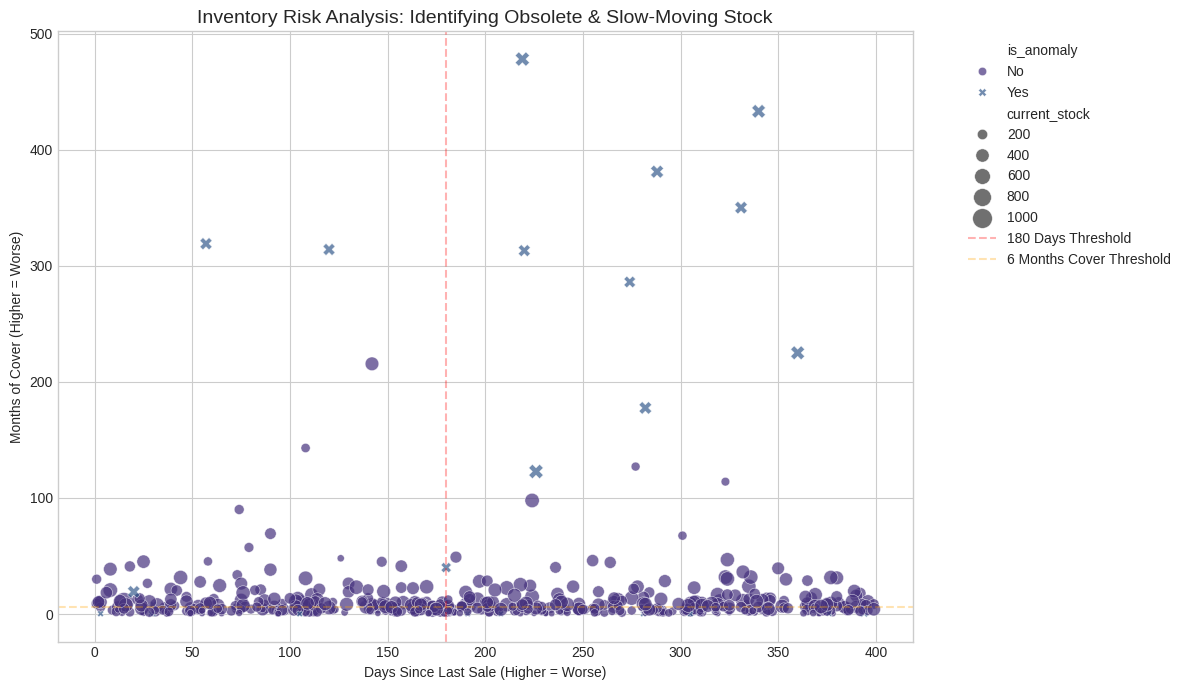

In [23]:
plt.figure(figsize=(12, 7))

# Create a scatter plot of Days Since Last Sale vs. Months of Cover
scatter = sns.scatterplot(
    data=df,
    x='days_since_last_sale',
    y='months_of_cover',
    hue='is_anomaly',
    style='is_anomaly',
    size='current_stock', # Size of point indicates the $ value of the problem
    sizes=(20, 200),
    alpha=0.7
)

# Highlight the extreme areas
plt.axvline(x=180, color='red', linestyle='--', alpha=0.3, label='180 Days Threshold')
plt.axhline(y=6, color='orange', linestyle='--', alpha=0.3, label='6 Months Cover Threshold')

plt.title('Inventory Risk Analysis: Identifying Obsolete & Slow-Moving Stock', fontsize=14)
plt.xlabel('Days Since Last Sale (Higher = Worse)')
plt.ylabel('Months of Cover (Higher = Worse)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()